In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torch
import scipy.io.wavfile as wavfile
import random 
from itertools import chain

In [6]:
cuda0 = torch.device("cuda:0")

In [11]:
class Dictlist(dict):
    def __setitem__(self, key, value):
        try:
            self[key]
        except KeyError:
            super(Dictlist, self).__setitem__(key, [])
            
        self[key].append(value)

In [36]:
d = {}
d["test"] = (1,2,3)
d["test"] = 2
d["test"] = 2
d["ahoj"] = 3

In [39]:
list(d.values())

[2, 3]

In [30]:
x = np.arange(1201, dtype=np.int32, step=10)

In [14]:
def find_index(idx, list_of_dict: list[dict]):
    length = len(list_of_dict)
    for i in range(length):
        if len(list(list_of_dict[i].values())) <= idx:
            return list(list_of_dict[i].values())[idx-1]
        idx -= len(list(list_of_dict[i].values()))
        

In [10]:
example_list = [
    {2: [2,3,4]},
    {4: [1,1,1,1]},
    {1: [3]},
    {2: [2,3,4,4,4,1]},
    {1: [1,1,1,1,1,1]},
]

In [125]:
example_list = [
    {2: np.array([2,3,4])},
    {4: np.array([1,1,1,1])},
    {1: np.array([3])},
    {2: np.array([2,3,4,4,4,1])},
    {1: np.array([1,1,1,1,1,1])},
]

# Flatten the list of lists
flattened_list = [(index, key, value) for index, dictionary in enumerate(example_list) for key, value in dictionary.items()]

# Function to get key and value by index
def get_key_value_by_index(index):
    # Calculate the cumulative length of arrays until the index
    cumulative_length = 0
    for position, key, value in flattened_list:
        cumulative_length += len(value)
        if index < cumulative_length:
            return position, key, value[index - (cumulative_length - len(value))]

# Test cases
test_indices = [0, 7, 19]
for index in test_indices:
    position, label, value = get_key_value_by_index(index)
    print(f"Index {index}: Position in dict: {position}, Label: {label}, Value: {value}")

Index 0: Position in dict: 0, Label: 2, Value: 2
Index 7: Position in dict: 2, Label: 1, Value: 3
Index 19: Position in dict: 4, Label: 1, Value: 1


In [32]:
class SignalDataset(Dataset):

    def __init__(self, step: int, window_size: int, paths_and_classes: dict,
                 reduction: float, device=torch.device("cpu")):
        source_dtype = "float32"
        self.step = step
        self.window_size = window_size

        paths = list(paths_and_classes)  # creates list of paths
        class_distribution = list(paths_and_classes.values())
        self.num_of_samples_per_class = []  # each element contains a number of samples in each class # Martin: per class nebo per bin? Zkus to udělat obecně rovnou tak, aby každá třída mohla mít víc bin souborů, pak to bude obecnější

        self._load_signals(paths, source_dtype)  # loads raw data in form of numpy arrray in to a list
        # self._create_sampling(class_distribution)

    def _load_signals(self, paths: list, dtype="float32"):
        self.loaded_signal = []
        for i, path in enumerate(paths):
            # count = np.fromfile(path, dtype=dtype).shape[0]
            self.loaded_signal.append(np.fromfile(path, dtype=dtype))

    def _create_sampling(self, class_distribution: list):
        self.sampled_signal = []
        for i, distribution in enumerate(class_distribution):

            full_length = np.sum(distribution.values())  # in seconds
            recording_size = self.loaded_signal[i].shape[0]  # number of points
            one_sec = recording_size / full_length  # number of points per one second
            shift = 0
            bins_per_label = CustomDict()
            for label, size in distribution.item():
                fraction_of_sample = size / full_length
                length_of_sample = fraction_of_sample * recording_size
                operated_signal = self.loaded_signal[i][shift + one_sec: shift + length_of_sample - one_sec]
                shift += length_of_sample
                bins_per_label[label] = self._create_binning(operated_signal)
            self.sampled_signal.append(bins_per_label)

    def _create_binning(self, signal):
        length = signal.shape[0]
        num_of_samples = (length - self.window_size) // self.step
        indices = np.arange(num_of_samples, dtype=np.int32, step=self.step)
        return indices

    def __len__(self):
        
        return np.sum(self.num_of_samples_per_class)

    def __getitem__(self, idx):
        


In [2]:

class CustomDict:
    def __init__(self):
        self._data = {}

    def __getitem__(self, key):
        return self._data[key]

    def __setitem__(self, key, value):
        if key in self._data:
            if isinstance(value, np.ndarray):
                self._data[key] = np.concatenate((self._data[key],value))
            else:
                raise TypeError("Only numpy arrays can be added to existing numpy arrays.")
        else:
            if isinstance(value, np.ndarray):
                self._data[key] = value
            else:
                raise TypeError("Values must be numpy arrays.")

    def __delitem__(self, key):
        del self._data[key]

    def keys(self):
        return self._data.keys()

    def values(self):
        return self._data.values()

    def items(self):
        return self._data.items()

    def __repr__(self):
        return repr(self._data)


In [3]:


def get_position_label_start_by_index(index, list_of_dicts: list[CustomDict]):
    # Initialize cumulative length
    cumulative_length = 0
    
    # Iterate through dictionaries in the list
    for i, dictionary in enumerate(list_of_dicts):
        # Iterate through key-value pairs in each dictionary
        for key, value in dictionary.items():
            # Calculate the cumulative length
            length = len(value)
            if index < cumulative_length + length:
                return i, key, value[index - cumulative_length]
            cumulative_length += length
    
    # If index is out of range, return None
    return None, None, None

In [4]:

class SignalDataset(Dataset):

    def __init__(self, step: int, window_size: int, paths_and_classes: dict, device=torch.device("cpu")):
        source_dtype = "float32"
        self.step = step
        self.window_size = window_size
        self.device = device

        paths = list(paths_and_classes)  # creates list of paths
        class_distribution = list(paths_and_classes.values())

        self._load_signals(paths, source_dtype)  # loads raw data in form of numpy arrray in to a list
        self._create_sampling(class_distribution)

    def _load_signals(self, paths: list, dtype="float32"):
        self.loaded_signal = []
        for i, path in enumerate(paths):
            # count = np.fromfile(path, dtype=dtype).shape[0]
            self.loaded_signal.append(np.fromfile(path, dtype=dtype))

    def _create_sampling(self, class_distributions: list):

        self.sampling = []
        self.num_of_samples = []

        for i, distribution in enumerate(class_distributions):

            assert len(distribution["size"]) == len(distribution["labels"]), "labels and sizes are mismatched"

            full_length = np.sum(distribution["size"])
            recording_size = self.loaded_signal[i].shape[0]  # number of points
            already_binned = 0
            shift = 4 * self.window_size  # later will be dependent on frequency of sensor
            bins_per_label = CustomDict()
            
            for idx in range(len(distribution["labels"])):
                # later will be size calculated based on the frequency and derived from actual seconds recorded
                fraction_of_sample = distribution["size"][idx] / full_length
                length_of_sample = int(np.floor(fraction_of_sample * recording_size))


                start = already_binned + shift
                end = length_of_sample + already_binned - shift
                bins = np.arange(start=start, stop=end, step=self.step)
                bins_per_label[distribution["labels"][idx]] = bins
                self.num_of_samples.append(bins.size)
                
                already_binned += length_of_sample
            self.sampling.append(bins_per_label)
    # 0:      26100000, 26171875: 52271875
    # 400000: 25700000, 26571875: 51871875

    def __len__(self):
        return np.sum(self.num_of_samples)

    def __getitem__(self, idx):
        position, label, start = get_position_label_start_by_index(idx, self.sampling)
        return torch.tensor(self.loaded_signal[position][start: start+self.window_size]), torch.tensor(label)



In [5]:
cuda0 = torch.device("cuda:0")
directory_of_signal_data = "/home/petr/Documents/Motor_projekt/Data"
list_of_paths = sorted(Path(directory_of_signal_data).glob('*.bin'))
list_of_classes = [{"labels": [0, 10], "size": [15, 15]},
                   {"labels": [1, 11], "size": [15, 15]},
                   {"labels": [2, 12], "size": [15, 15]},
                   {"labels": [3, 13], "size": [15, 15]},
                   {"labels": [4, 14], "size": [15, 15]},
                   {"labels": [5, 15], "size": [15, 15]},
                   {"labels": [6, 16], "size": [15, 15]},
                   {"labels": [7, 17], "size": [15, 15]},
                   {"labels": [8, 18], "size": [15, 15]}]

data_specs = dict(zip(list_of_paths, list_of_classes))


dataset = SignalDataset(step=1000, window_size=1000, paths_and_classes=data_specs, device=cuda0)

In [6]:
len(dataset)

464694

In [7]:
dataset[len(dataset)-1]

(tensor([ 3.7818e-04,  6.1376e-04,  6.9436e-04,  4.5257e-04,  8.8035e-04,
          9.2374e-04,  1.0725e-03,  1.2771e-03,  1.3701e-03,  1.6925e-03,
          1.1965e-03,  1.2089e-03,  1.4879e-03,  1.3515e-03,  1.2833e-03,
          1.1221e-03,  1.2771e-03,  1.1655e-03,  1.5313e-03,  1.4383e-03,
          1.5685e-03,  1.8413e-03,  1.8041e-03,  1.7173e-03,  1.9157e-03,
          2.1947e-03,  2.6100e-03,  2.1079e-03,  2.3559e-03,  2.6162e-03,
          2.0459e-03,  2.1451e-03,  2.1761e-03,  2.2443e-03,  1.9219e-03,
          1.6553e-03,  2.0893e-03,  2.0831e-03,  1.8537e-03,  1.2523e-03,
          1.6739e-03,  1.9715e-03,  2.5356e-03,  2.1823e-03,  1.8041e-03,
          2.0149e-03,  2.3621e-03,  1.9281e-03,  1.7731e-03,  2.1079e-03,
          1.6429e-03,  2.0149e-03,  1.8165e-03,  1.8351e-03,  1.4569e-03,
          1.2833e-03,  1.8351e-03,  2.0211e-03,  1.6181e-03,  1.7173e-03,
          2.0335e-03,  2.0521e-03,  2.1761e-03,  2.0583e-03,  2.1947e-03,
          1.7359e-03,  1.7917e-03,  2.

In [8]:
dataset.sampling

[{0: array([    4000,     5000,     6000, ..., 52337070, 52338070, 52339070]), 10: array([22437035, 22438035, 22439035, ..., 44860035, 44861035, 44862035])},
 {1: array([    4000,     5000,     6000, ..., 12884000, 12885000, 12886000]), 11: array([12894625, 12895625, 12896625, ..., 25774625, 25775625, 25776625]), 0: array([25785250, 25786250, 25787250, ..., 51556250, 51557250, 51558250])},
 {2: array([    4000,     5000,     6000, ..., 25775000, 25776000, 25777000]), 12: array([25785250, 25786250, 25787250, ..., 51556250, 51557250, 51558250])},
 {3: array([    4000,     5000,     6000, ..., 25384000, 25385000, 25386000]), 13: array([25394625, 25395625, 25396625, ..., 50774625, 50775625, 50776625])},
 {4: array([    4000,     5000,     6000, ..., 25384000, 25385000, 25386000]), 14: array([25394625, 25395625, 25396625, ..., 50774625, 50775625, 50776625])},
 {5: array([    4000,     5000,     6000, ..., 25384000, 25385000, 25386000]), 15: array([25394625, 25395625, 25396625, ..., 50774625

In [20]:
position, label, start = get_position_label_start_by_index(211111, dataset.sampling)
print(position, label, start)

4 4 4925000


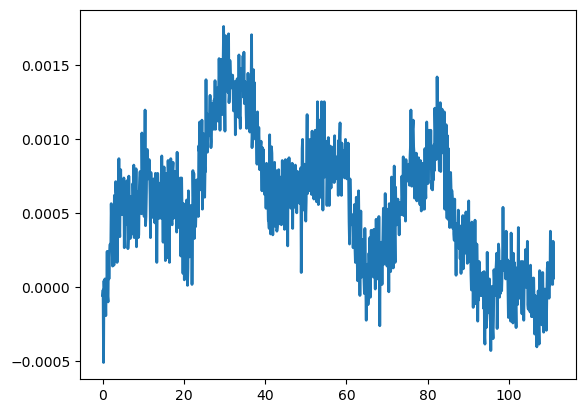

In [7]:
x = np.linspace(start=0, stop=111, num=1000)
y = dataset[440][0]
fig, ax = plt.subplots()


ax.plot(x, y, linewidth=2.0)

plt.show()

In [4]:
source_dtype='float32'

def read_bin(filename, interval: tuple[int, int] = None, source_dtype='float32') -> np.ndarray:
        count = (interval[1] - interval[0]) if interval is not None else -1
        file = np.fromfile(filename, dtype=source_dtype, count=count)
        return 

wup_path = Path('/home/petr/Documents/Motor_projekt/Data/wup_50.bin')


wup_50 = np.fromfile(wup_path, dtype=source_dtype)
sample_rate = 48000
print(wup_50)

[ 5.5796652e-05 -2.9138252e-04  9.2994422e-05 ... -6.6336017e-04
 -1.1717296e-03 -6.2616245e-04]


In [5]:
def convert_to_wav(binary_file, output_file):
    # Read binary data into a numpy array
    data = np.fromfile(binary_file, dtype=source_dtype)


    sample_rate = 1410000

    # Convert numpy array to WAV format
    wavfile.write(output_file, sample_rate, data)
    
wup_path = Path('/home/petr/Documents/Motor_projekt/Data/wup_90.bin')
output_file = 'wup_50.wav'
convert_to_wav(wup_path, output_file)

In [ ]:
# for ploting
for i, val in enumerate(data):
    # data[i] = only_pure_signal(data)
    print(wup[i].shape)
    x = np.linspace(start=0, stop=15000000, num=wup[i].shape[0])
    fig, ax = plt.subplots()
    ax.plot(x, data[i], linewidth=1.0)

    plt.show()

In [56]:
d1=22 #random délka
data=np.random.rand(d1) #dummy data
print(data.shape)

offset=2 #skok
size=3 #sirka okna
rows=(d1)//offset #kolik ramcu budu mit na datech
print("data frames:" + str(rows) )


(22,)
data frames:11
